# Suicide Location Clustering

## 🧩 Step 1: Load and prepare the data


In [1]:
import json
import folium
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

# Load data
df = pd.read_csv("../dataset/suicide.csv")
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

# Convert coordinates to radians for haversine metric
coords = np.radians(df[["Latitude", "Longitude"]].values)

## Step 2: Apply DBSCAN clustering with Haversine distance

In [2]:
# Apply DBSCAN using haversine metric with approx. 1km radius
db = DBSCAN(eps=2 / 6371, min_samples=50, metric='haversine')
df["cluster"] = db.fit_predict(coords)

## 🧩 Step 3: Create base map

In [3]:
# Initialize a Folium map centered on Hong Kong
m = folium.Map(location=[22.35, 114.15], zoom_start=11)

## 🧩 Step 4: Load GeoJSON boundaries


In [4]:
# Load GeoJSON for 18 Districts
with open("../dataset/HK18Districts.geojson", "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

# Add GeoJSON layer to map with tooltip showing district name
folium.GeoJson(
    geojson_data,
    name="Hong Kong 18 Districts",
    style_function=lambda feature: {
        "fillColor": "#cccccc",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.1
    },
    tooltip=folium.GeoJsonTooltip(fields=["CNAME"])
).add_to(m)

## 🧩 Step 5: Assign colors to each cluster

In [5]:
# Define a color list for clusters
colors = [
    "red", "blue", "green", "purple", "orange", "darkred", "lightred",
    "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple",
    "white", "pink", "lightblue", "lightgreen", "gray", "black"
]

# Map each cluster ID to a color
unique_clusters = sorted(df["cluster"].unique())
cluster_colors = {
    cluster_id: colors[i % len(colors)] if cluster_id != -1 else "gray"
    for i, cluster_id in enumerate(unique_clusters)
}

## 🧩 Step 6: Add clustered points to the map


In [6]:
# Add each point to the map with cluster color and popup info
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=6,
        color=cluster_colors[row["cluster"]],
        fill=True,
        fill_opacity=0.8,
        popup=f"{row['District']} {row['Unit']}<br>Cluster: {row['cluster']}"
    ).add_to(m)

## 🧩 Step 7: Add cluster center markers and print location info


In [7]:
print("\n📍 Cluster centers (excluding noise):")
for cluster_id in unique_clusters:
    if cluster_id == -1:
        continue  # Skip noise

    cluster_points = df[df["cluster"] == cluster_id]
    center_lat = cluster_points["Latitude"].mean()
    center_lon = cluster_points["Longitude"].mean()

    # Find the point nearest to the center
    distances = ((cluster_points["Latitude"] - center_lat) ** 2 +
                 (cluster_points["Longitude"] - center_lon) ** 2)
    nearest_point = cluster_points.loc[distances.idxmin()]

    # Extract location info from the nearest point
    district_info = f"{nearest_point.get('District', '')} {nearest_point.get('subDistrict', '')} {nearest_point.get('Unit', '')} {nearest_point.get('subUnit', '')}".strip()

    # Print to console
    print(f"Cluster {cluster_id}: ({center_lat:.5f}, {center_lon:.5f}) - Area: {district_info}")

    # Add cluster center marker to map
    folium.Marker(
        location=[center_lat, center_lon],
        icon=folium.Icon(color="black", icon="star", prefix="fa"),
        popup=(f"<b>Cluster {cluster_id} Center</b><br>"
               f"Location: ({center_lat:.5f}, {center_lon:.5f})<br>"
               f"Area: {district_info}")
    ).add_to(m)


📍 Cluster centers (excluding noise):
Cluster 0: (22.32637, 114.18198) - Area: 九龍城區 九龍仔 喇沙利道 Caravelle Villa
Cluster 1: (22.47538, 114.15026) - Area: 大埔區 八仙嶺 一停車場 現場
Cluster 2: (22.42329, 113.99309) - Area: 屯門區 藍地 達福路 一汽車
Cluster 3: (22.28681, 113.94054) - Area: 離島區 東涌 富東邨 東盛樓


## 🧩 Step 8: Save the map to HTML


In [8]:
# Save the final interactive map
m.save("suicide_clusters_with_geojson.html")
print("✅ Map saved to suicide_clusters_with_geojson.html")

✅ Map saved to suicide_clusters_with_geojson.html


## 🧩 Step 9: Display point counts for each cluster (including noise)

In [9]:
# Count number of points in each cluster (including noise)
cluster_counts = df["cluster"].value_counts().sort_index()
print("\n📊 Number of points in each cluster:")
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"Cluster -1 (Noise): {count} points")
    else:
        print(f"Cluster {cluster_id}: {count} points")


📊 Number of points in each cluster:
Cluster -1 (Noise): 260 points
Cluster 0: 4937 points
Cluster 1: 434 points
Cluster 2: 821 points
Cluster 3: 84 points


## 🧩 Step 10: Evaluate clustering performance (excluding noise)

In [10]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Only use non-noise data for evaluation
df_valid = df[df["cluster"] != -1]
X = np.radians(df_valid[["Latitude", "Longitude"]].values)  # same format as clustering
labels = df_valid["cluster"].values
n_clusters = len(set(labels))

if n_clusters > 1:
    sil_score = silhouette_score(X, labels, metric="euclidean")
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)

    print("\n📈 Internal evaluation metrics (excluding noise):")
    print(f"🔹 Silhouette Coefficient: {sil_score:.4f}  (closer to 1 is better)")
    print(f"🔹 Davies-Bouldin Index:   {db_score:.4f}  (lower is better)")
    print(f"🔹 Calinski-Harabasz Index: {ch_score:.2f} (higher is better)")
else:
    print("\n⚠️ Not enough clusters to compute evaluation metrics.")


📈 Internal evaluation metrics (excluding noise):
🔹 Silhouette Coefficient: 0.5412  (closer to 1 is better)
🔹 Davies-Bouldin Index:   0.4525  (lower is better)
🔹 Calinski-Harabasz Index: 4871.44 (higher is better)


# Association Rule Mining (Location -> Method)

## 🧩 Step 1: Load data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Support Traditional Chinese font in plots
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

# Load CSV data
df = pd.read_csv("../dataset/suicide.csv")

## 🧩 Step 2: Construct transaction records from location and suicide methods

In [13]:
# Each transaction = {subUnit + House, Method(s)}
records = []
for _, row in df.iterrows():
    items = set()

    # Combine location info: subUnit + House
    if pd.notna(row["subUnit"]) and pd.notna(row["House"]):
        place = f"{row['subUnit'].strip()}_{row['House'].strip()}"
        items.add(place)

    # Add all suicide methods
    for col in ["type1", "type2", "type3"]:
        if pd.notna(row[col]) and row[col].strip() != "":
            items.add(f"Method_{row[col].strip()}")

    if items:
        records.append(list(items))

## 🧩 Step 3: Convert to boolean matrix

In [14]:
te = TransactionEncoder()
te_ary = te.fit(records).transform(records)
df_bool = pd.DataFrame(te_ary, columns=te.columns_)

## 🧩 Step 4: Run Apriori algorithm

In [15]:
frequent_itemsets = apriori(df_bool, min_support=0.00784806, use_colnames=True) # 50 cases

## 🧩 Step 5: Generate association rules

In [16]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules[rules['consequents'].apply(lambda x: any('Method_' in i for i in x))]

## 🧩 Step 6: Sort rules by lift

In [17]:
rules_sorted = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']] \
    .sort_values(by='lift', ascending=False)

rules_sorted

,antecedents,consequents,support,confidence,lift
0,(對開海面_非住宅),(Method_淹溺),0.070073,0.993492,11.432159
4,(一汽車_非住宅),(Method_燒炭),0.015453,0.901786,8.456344
6,(附近樹上_非住宅),(Method_自縊),0.008109,1.000000,6.724280
3,(一單位_村屋),(Method_燒炭),0.011169,0.477124,4.474152
12,(高處_非住宅),(Method_跳落),0.084302,0.998188,1.774316
8,(一大廈高處_私人屋苑),(Method_跳落),0.018054,0.975207,1.733465
11,(行人天橋_非住宅),(Method_跳落),0.017136,0.949153,1.687153


## 🧩 Step 7: Visualize the rules as a bubble chart

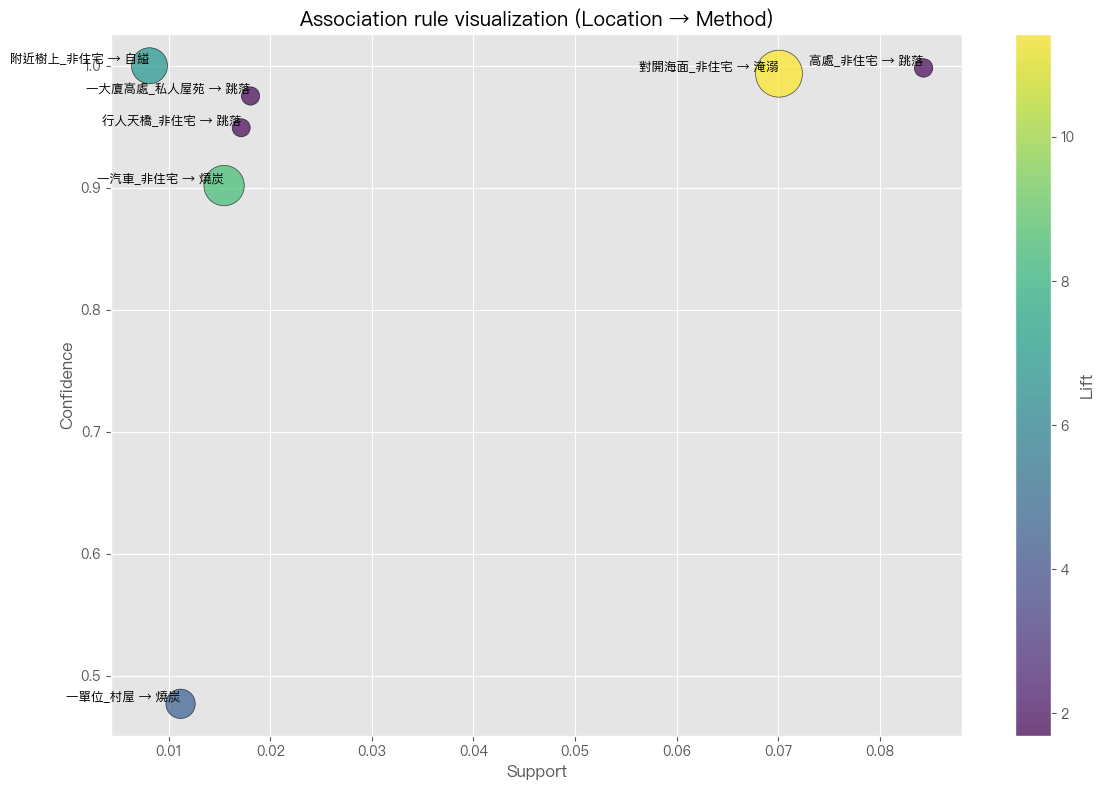

In [18]:
plt.figure(figsize=(12, 8))

# Bubble size = lift * 100
bubble_size = rules_sorted['lift'] * 100

# Create readable labels
labels = rules_sorted.apply(
    lambda row: f"{list(row['antecedents'])[0]} → {list(row['consequents'])[0].replace('Method_', '')}",
    axis=1
)

# Draw the scatter plot
scatter = plt.scatter(
    rules_sorted['support'],
    rules_sorted['confidence'],
    s=bubble_size,
    c=rules_sorted['lift'],
    cmap='viridis',
    alpha=0.7,
    edgecolors='k'
)

# Add text labels
for i, label in enumerate(labels):
    plt.text(
        rules_sorted['support'].iloc[i],
        rules_sorted['confidence'].iloc[i],
        label,
        fontsize=9,
        ha='right',
        va='bottom'
    )

plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association rule visualization (Location → Method)')
plt.grid(True)
plt.tight_layout()
plt.show()